In [1]:
import pandas as pd
import numpy as np
import glob

## Introduction (WIP)

...

## Data overview

### train.csv - metadata for the train files
**segment_id:** ID code for the data segment. Matches the name of the associated data file.<br>
**time_to_eruption:** the target value, the time until the next eruption.

In [2]:
train = pd.read_csv("train.csv")
print(train)

      segment_id  time_to_eruption
0     1136037770          12262005
1     1969647810          32739612
2     1895879680          14965999
3     2068207140          26469720
4      192955606          31072429
...          ...               ...
4426   873340274          15695097
4427  1297437712          35659379
4428   694853998          31206935
4429  1886987043           9598270
4430  1100632800          20128938

[4431 rows x 2 columns]


**Time to eruption distribution**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000157EEC95130>]],
      dtype=object)

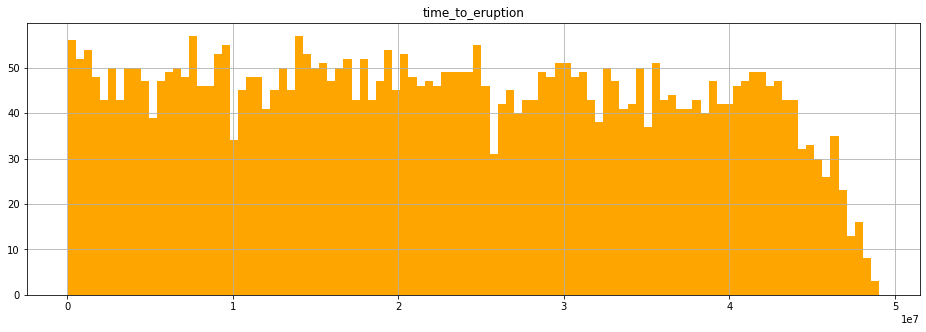

In [3]:
# Võiks siia panna veel x- ja y- labelid (y count, x time_to_eruption)
# x- teljel tunduvad numbrid paiast ära olevat??? Peaks olema 0-50M

train.hist(column="time_to_eruption", bins=100, color="orange", figsize=(16,5))

**Time to eruption for all volcanos**

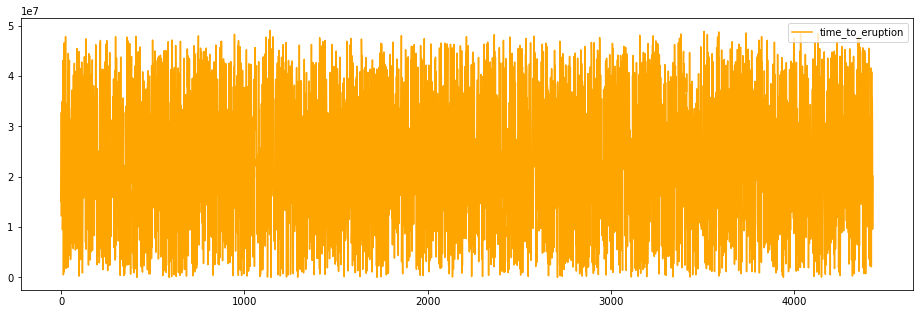

In [4]:
# Võiks siia panna veel x- ja y- labelid (y time_to_eruption (0-50M), x index)

train.plot(y = "time_to_eruption", color="orange", figsize=(16,5))

In [5]:
train['time_to_eruption'].describe()

count    4.431000e+03
mean     2.284891e+07
std      1.348439e+07
min      6.250000e+03
25%      1.127016e+07
50%      2.246559e+07
75%      3.434356e+07
max      4.904609e+07
Name: time_to_eruption, dtype: float64

In [6]:
print('Median:', train['time_to_eruption'].median())
print('Skew:', train['time_to_eruption'].skew())
print('Kurtosis:', train['time_to_eruption'].kurtosis())

Median: 22465586.0
Skew: 0.059347778798359965
Kurtosis: -1.166601027916375


### sample_submission.csv
**segment_id:** ID code for the data segment. Matches the name of the associated data file.<br>
**time_to_eruption:** the target value, the time until the next eruption, but as it is sample_submission file then they are all zeros. Therefore we dropped the column.

We will add all of the sensors information and also the predictions in this created dataframe.

In [7]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission = sample_submission.drop(columns=['time_to_eruption'])
print(sample_submission)

      segment_id
0     1000213997
1      100023368
2     1000488999
3     1001028887
4     1001857862
...          ...
4515   996704281
4516   997630809
4517   998072137
4518   998136924
4519    99975682

[4520 rows x 1 columns]


## train/-.csv and test/-.csv - the data files. 
**Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. There are 60000 rows in each file.**

In [8]:
# example
check = pd.read_csv('train/2071930.csv')
check

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,449.0,199.0,-56.0,-214.0,156.0,102.0,-104.0,-277.0,451.0,-1116.0
1,465.0,-123.0,-47.0,-202.0,24.0,104.0,-119.0,-179.0,464.0,-1107.0
2,485.0,-334.0,-36.0,-224.0,39.0,58.0,-132.0,-373.0,464.0,-1070.0
3,520.0,124.0,-20.0,-199.0,10.0,0.0,-147.0,-360.0,459.0,-1004.0
4,514.0,44.0,-24.0,-176.0,-31.0,-15.0,-157.0,-267.0,446.0,-920.0
...,...,...,...,...,...,...,...,...,...,...
59996,78.0,140.0,322.0,188.0,-74.0,-35.0,124.0,35.0,-212.0,967.0
59997,141.0,68.0,428.0,263.0,-42.0,40.0,146.0,-92.0,-199.0,833.0
59998,200.0,-32.0,305.0,342.0,-97.0,41.0,173.0,-94.0,-211.0,678.0
59999,209.0,-101.0,437.0,346.0,-96.0,-31.0,157.0,-179.0,-185.0,494.0


In [9]:
train_frags = glob.glob("train/*")
#print(len(train_frags))

test_frags = glob.glob("test/*")
#print(len(test_frags))

In [10]:
%%time
sensors = set()
observations = set()
nan_columns = list()
for_df = list()

for item in train_frags:
    name = int(item.split('.')[-2].split('\\')[-1])
    at_least_one_missed = 0
    frag = pd.read_csv(item)
    missed_percents = list()
    for col in frag.columns:
        missed_percents.append(frag[col].isnull().sum() / len(frag))
        if pd.isnull(frag[col]).all() == True:
            at_least_one_missed = 1
            nan_columns.append(col)
    sensors.add(len(frag.columns))
    observations.add(len(frag))
    for_df.append([name, at_least_one_missed] + missed_percents)

Wall time: 6min 21s


**Number of missed sensors in training dataset**

In [11]:
print('Number of totally missed sensors in train:', len(nan_columns))

absent_sensors = dict()

for item in nan_columns:
    if item in absent_sensors:
        absent_sensors[item] += 1
    else:
        absent_sensors[item] = 0

Number of totally missed sensors in train: 2519


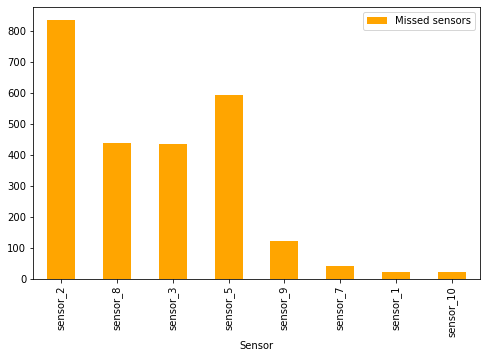

In [12]:
absent_df = pd.DataFrame(absent_sensors.items(), columns=['Sensor', 'Missed sensors'])

absent_df.plot(x="Sensor", y="Missed sensors", kind="bar", color="orange", figsize=(8,5))

In [13]:
%%time
sensors = set()
observations = set()
nan_columns = list()
for_test_df = list()

for item in test_frags:
    name = int(item.split('.')[-2].split('\\')[-1])
    at_least_one_missed = 0
    frag = pd.read_csv(item)
    missed_percents = list()
    for col in frag.columns:
        missed_percents.append(frag[col].isnull().sum() / len(frag))
        if pd.isnull(frag[col]).all() == True:
            at_least_one_missed = 1
            nan_columns.append(col)
    sensors.add(len(frag.columns))
    observations.add(len(frag))
    for_test_df.append([name, at_least_one_missed] + missed_percents)

Wall time: 6min 6s


**Number of missed sensors in test dataset**

In [14]:
print('Number of totally missed sensors in test:', len(nan_columns))

absent_sensors = dict()

for item in nan_columns:
    if item in absent_sensors:
        absent_sensors[item] += 1
    else:
        absent_sensors[item] = 0

Number of totally missed sensors in test: 5371


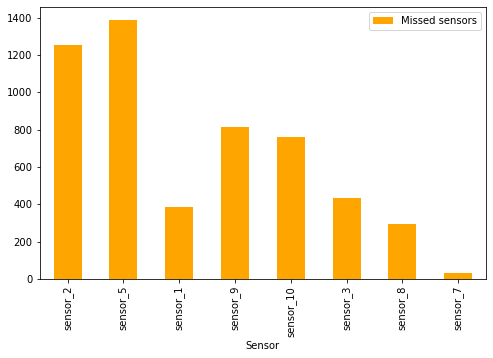

In [15]:
absent_df = pd.DataFrame(absent_sensors.items(), columns=['Sensor', 'Missed sensors'])

absent_df.plot(x="Sensor", y="Missed sensors", kind="bar", color="orange", figsize=(8,5))

**All sensors information plotted from the example file train/2071930.csv**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000157EECA9790>,
      dtype=object)

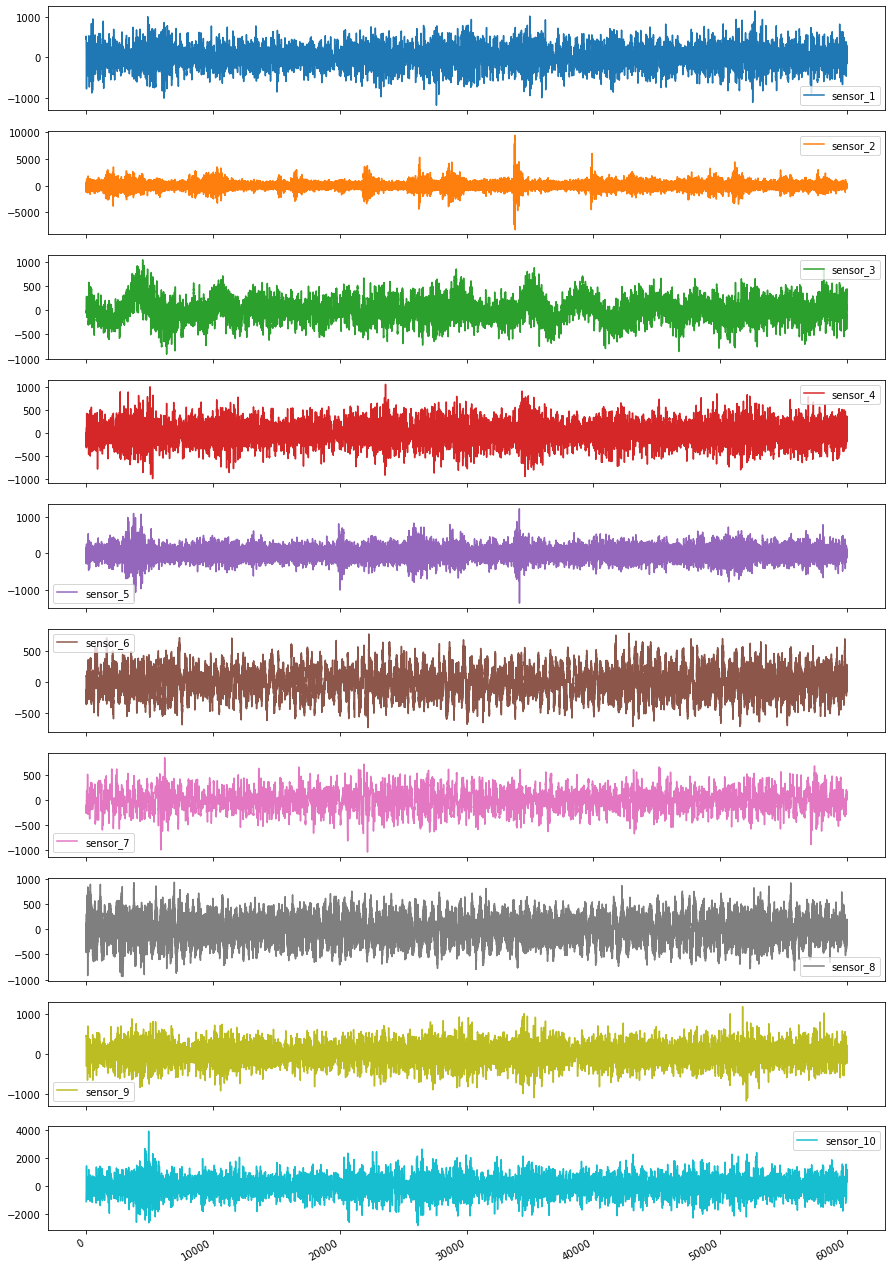

In [16]:
check.plot(subplots=True, figsize=(15, 25))

## Data systematization

In [24]:
%%time
sensorDict1 = {'sensor1mean': [],'sensor1max':[],'sensor1min':[],'sensor1std':[],
               'sensor2mean': [],'sensor2max':[],'sensor2min':[],'sensor2std':[],
               'sensor3mean': [],'sensor3max':[],'sensor3min':[],'sensor3std':[],
               'sensor4mean': [],'sensor4max':[],'sensor4min':[],'sensor4std':[],
               'sensor5mean': [],'sensor5max':[],'sensor5min':[],'sensor5std':[],
               'sensor6mean': [],'sensor6max':[],'sensor6min':[],'sensor6std':[],
               'sensor7mean': [],'sensor7max':[],'sensor7min':[],'sensor7std':[],
               'sensor8mean': [],'sensor8max':[],'sensor8min':[],'sensor8std':[],
               'sensor9mean': [],'sensor9max':[],'sensor9min':[],'sensor9std':[],
               'sensor10mean': [],'sensor10max':[],'sensor10min':[],'sensor10std':[],
               }

for id in train.segment_id:
    name = "train/" + str(id) + ".csv"
    volcanoData = pd.read_csv(name)
    #print(volcanoData.head())
    means = volcanoData.mean()
    maxs = volcanoData.max()
    mins = volcanoData.min()
    stds = volcanoData.std()
    for i in range(10):
        sensorDict1['sensor'+str(i+1)+'mean'].append(means[i])
        sensorDict1['sensor'+str(i+1)+'max'].append(maxs[i])
        sensorDict1['sensor'+str(i+1)+'min'].append(mins[i])
        sensorDict1['sensor'+str(i+1)+'std'].append(stds[i])
#print(sensorDict1)

Wall time: 5min 36s


In [26]:
placement = 1
for i in range(1, 11):
    train.insert(placement, "sensor"+str(i)+"mean", sensorDict1["sensor"+str(i)+"mean"])
    train.insert(placement+1, "sensor"+str(i)+"max", sensorDict1["sensor"+str(i)+"max"])
    train.insert(placement+2, "sensor"+str(i)+"min", sensorDict1["sensor"+str(i)+"min"])
    train.insert(placement+3, "sensor"+str(i)+"std", sensorDict1["sensor"+str(i)+"std"])
    placement += 4
    
print(train.head())

ValueError: cannot insert sensor1mean, already exists

In [29]:
train = train.drop(['sensor1', 'sensor2', 'sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10'], axis=1)

print(train.head())

   segment_id  sensor1mean  sensor1max  sensor1min  sensor1std  sensor2mean  \
0  1136037770    -1.610323      1353.0     -1421.0  303.096099     4.613823   
1  1969647810     1.426126      2197.0     -2005.0  438.360560     2.484442   
2  1895879680     2.504592      1148.0     -1115.0  241.575415     5.449709   
3  2068207140     2.165797      1254.0     -1025.0  221.967825    -0.373377   
4   192955606     0.073815      1114.0     -1190.0  261.695935          NaN   

   sensor2max  sensor2min  sensor2std  sensor3mean  ...  sensor8std  \
0      5572.0     -5199.0  678.330828     3.559724  ...  620.950335   
1      5111.0     -4267.0  661.163255    -2.794270  ...  364.990225   
2      7587.0     -6147.0  831.469221    -1.588540  ...  350.322141   
3      2453.0     -2828.0  425.189594    -2.698988  ...  321.893273   
4         NaN         NaN         NaN     1.998883  ...  412.606384   

   sensor9mean  sensor9max  sensor9min  sensor9std  sensor10mean  sensor10max  \
0     1.465042   

In [30]:
%%time

sensorDict2 = {'sensor1mean': [],'sensor1max':[],'sensor1min':[],'sensor1std':[],
               'sensor2mean': [],'sensor2max':[],'sensor2min':[],'sensor2std':[],
               'sensor3mean': [],'sensor3max':[],'sensor3min':[],'sensor3std':[],
               'sensor4mean': [],'sensor4max':[],'sensor4min':[],'sensor4std':[],
               'sensor5mean': [],'sensor5max':[],'sensor5min':[],'sensor5std':[],
               'sensor6mean': [],'sensor6max':[],'sensor6min':[],'sensor6std':[],
               'sensor7mean': [],'sensor7max':[],'sensor7min':[],'sensor7std':[],
               'sensor8mean': [],'sensor8max':[],'sensor8min':[],'sensor8std':[],
               'sensor9mean': [],'sensor9max':[],'sensor9min':[],'sensor9std':[],
               'sensor10mean': [],'sensor10max':[],'sensor10min':[],'sensor10std':[],
               }

for id in sample_submission.segment_id:
    name = "test/" + str(id) + ".csv"
    volcanoData = pd.read_csv(name)
    #print(volcanoData.head())
    means = volcanoData.mean()
    maxs = volcanoData.max()
    mins = volcanoData.min()
    stds = volcanoData.std()
    for i in range(10):
        sensorDict2['sensor'+str(i+1)+'mean'].append(means[i])
        sensorDict2['sensor'+str(i+1)+'max'].append(maxs[i])
        sensorDict2['sensor'+str(i+1)+'min'].append(mins[i])
        sensorDict2['sensor'+str(i+1)+'std'].append(stds[i])

#print(sensorDict2)

Wall time: 6min 45s


In [31]:
sample_submission = sample_submission.drop(['sensor1', 'sensor2', 'sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10'], axis=1)

placement = 1
for i in range(1, 11):
    sample_submission.insert(placement, "sensor"+str(i)+"mean", sensorDict2["sensor"+str(i)+"mean"])
    sample_submission.insert(placement+1, "sensor"+str(i)+"max", sensorDict2["sensor"+str(i)+"max"])
    sample_submission.insert(placement+2, "sensor"+str(i)+"min", sensorDict2["sensor"+str(i)+"min"])
    sample_submission.insert(placement+3, "sensor"+str(i)+"std", sensorDict2["sensor"+str(i)+"std"])
    placement += 4

print(sample_submission.head())

   segment_id  sensor1mean  sensor1max  sensor1min  sensor1std  sensor2mean  \
0  1000213997     4.462476      1347.0     -1319.0  306.174474          NaN   
1   100023368     0.838103      1214.0     -1268.0  335.591100          NaN   
2  1000488999     0.794903      4259.0     -3806.0  352.172248    -4.740871   
3  1001028887     1.953717      1220.0     -1156.0  259.030122          NaN   
4  1001857862    -3.984584       972.0     -1111.0  254.306426    -3.306728   

   sensor2max  sensor2min  sensor2std  sensor3mean  ...  sensor8min  \
0         NaN         NaN         NaN     3.584690  ...     -3713.0   
1         NaN         NaN         NaN     1.009217  ...     -1823.0   
2      3140.0     -3552.0  506.432742     2.116098  ...     -1424.0   
3         NaN         NaN         NaN     0.404360  ...    -17453.0   
4     11615.0    -10521.0  746.305062     0.898585  ...     -7871.0   

   sensor8std  sensor9mean  sensor9max  sensor9min  sensor9std  sensor10mean  \
0  379.065748    -

In [32]:
train = train.fillna(0)
sample_submission = sample_submission.fillna(0)

## Prediction

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

X_train = train[train.columns.difference(['segment_id', 'time_to_eruption'])]
y_train = train['time_to_eruption']

#sub1 model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=3).fit(X_train, y_train)
#sub2 model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=3).fit(X_train, y_train)
#sub3 model = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train, y_train)
#sub4 model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
#sub5 model = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=3).fit(X_train, y_train)
#model = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=3).fit(X_train, y_train)

#sub6 - mean, min, max, std model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=3).fit(X_train, y_train)
#sub 7 model = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=3).fit(X_train, y_train)
#sub 8 model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=3).fit(X_train, y_train)
#sub9 model = RandomForestClassifier(n_estimators=150, max_depth=13, random_state=3).fit(X_train, y_train)
model = RandomForestClassifier(n_estimators=200, max_depth=13, random_state=3).fit(X_train, y_train)


X_sample_submission = sample_submission[sample_submission.columns.difference(['segment_id'])]

predictions = model.predict(X_sample_submission)

final = pd.DataFrame(predictions)
final.insert(0,'segment_id',sample_submission.segment_id)
final = final.rename(columns={'segment_id': 'segment_id', '0': 'time_to_eruption'})

In [42]:
final.to_csv('submission9.csv',encoding='utf-8', index=False)